New Labelling
A drought is consecutive if:

A first drought (SPI ≤ -1.0) is detected.

The region begins to recover (SPI ≥ -0.5).

Within the specified recovery period, a new drought starts.

If a new drought starts within the recovery period, it is labeled as a consecutive drought.

This continues until the region fully recovers for the full recovery_period without any droughts (SPI ≤ -1.0).

In [1]:
import os
import xarray as xr
import numpy as np

# === Path Settings ===
region = "NET"  # Change this to your region name
recovery_period = 3  # Set the recovery period (drought-free months)
input_file = r"Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc"  # Change this to your file path
output_file = r"Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc"

# === Load the Combined Region File ===
ds = xr.open_dataset(input_file)
print(f"✅ Loaded Region File: {input_file}")

# === Fixed SPI Threshold (-1.0) ===
spi_threshold = -1.0
recovery_threshold = -0.5  # Recovery threshold (SPI ≥ -0.5)

# === Initialize Labels (With NaNs Preserved) ===
drought = np.full_like(ds["spi_1"].values, np.nan)
severity = np.full_like(ds["spi_1"].values, np.nan)
consecutive_drought = np.full_like(ds["spi_1"].values, np.nan)

# === Complete Drought Severity Classification (NaN-Aware) ===
valid_mask = ~np.isnan(ds["spi_1"].values)  # Only process valid (non-NaN) values

# === Apply Drought Severity (Only Non-NaN Regions) ===
severity[valid_mask & (ds["spi_1"] >= 2.0)] = 7      # Extremely Wet
severity[valid_mask & (ds["spi_1"] >= 1.5) & (ds["spi_1"] < 2.0)] = 6  # Very Wet
severity[valid_mask & (ds["spi_1"] >= 1.0) & (ds["spi_1"] < 1.5)] = 5  # Moderately Wet
severity[valid_mask & (ds["spi_1"] >= 0.0) & (ds["spi_1"] < 1.0)] = 4  # Normal
severity[valid_mask & (ds["spi_1"] >= -0.99) & (ds["spi_1"] < 0.0)] = 3 # Near Normal
severity[valid_mask & (ds["spi_1"] >= -1.49) & (ds["spi_1"] < -1.0)] = 2 # Moderately Dry
severity[valid_mask & (ds["spi_1"] >= -1.99) & (ds["spi_1"] < -1.5)] = 1 # Severely Dry
severity[valid_mask & (ds["spi_1"] <= -2.0)] = 0      # Extremely Dry

# === Drought Labeling ===
drought[valid_mask & (ds["spi_1"] <= spi_threshold)] = 1
drought[~valid_mask] = np.nan  # Preserve NaNs

# === Continuous Consecutive Drought Labeling ===
for lat in range(drought.shape[1]):
    for lon in range(drought.shape[2]):
        if not np.isnan(drought[:, lat, lon]).all():
            drought_series = drought[:, lat, lon]
            spi_series = ds["spi_1"][:, lat, lon]
            consecutive_series = np.zeros_like(drought_series)
            in_drought = False
            recovery_start = None

            for t in range(1, len(drought_series)):
                if np.isnan(spi_series[t]):
                    continue

                if drought_series[t] == 1:
                    if in_drought:
                        consecutive_series[t] = 1
                    else:
                        if recovery_start is not None:
                            if (t - recovery_start) <= recovery_period:
                                consecutive_series[t] = 1
                        in_drought = True
                        recovery_start = None

                else:
                    if in_drought:
                        if spi_series[t] >= recovery_threshold:
                            recovery_start = t
                            in_drought = False
                        else:
                            recovery_start = None

            consecutive_drought[:, lat, lon] = consecutive_series

# === Add Labels to the Dataset (NaN Preserved) ===
ds["drought"] = (("time", "lat", "lon"), drought.data)
ds["drought_severity"] = (("time", "lat", "lon"), severity)
ds["consecutive_drought"] = (("time", "lat", "lon"), np.where(valid_mask, consecutive_drought, np.nan))

# === Save the Labeled File ===
ds.to_netcdf(output_file)
print(f"✅ Saved Labeled Region File: {output_file}")


✅ Loaded Region File: Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc
✅ Saved Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc


In [ ]:
import os
import xarray as xr
import numpy as np

# === Path Settings ===
region = "NET"  # Change this to your region name
recovery_period = 3  # Set the recovery period (drought-free months)
input_file = r"Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc"  # Change this to your file path
output_file = r"Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc"

# === Load the Combined Region File ===
ds = xr.open_dataset(input_file)
print(f"✅ Loaded Region File: {input_file}")

# === Fixed SPI Threshold (-1.0) ===
spi_threshold = -1.0
recovery_threshold = -0.5  # Recovery threshold (SPI ≥ -0.5)

# === Generate NaN Mask (Regions with No Data) ===
nan_mask = np.isnan(ds["spi_1"].values)

# === Initialize Labels (With NaNs Preserved) ===
drought = np.full_like(ds["spi_1"].values, np.nan)
severity = np.full_like(ds["spi_1"].values, np.nan)
consecutive_drought = np.full_like(ds["spi_1"].values, np.nan)

# === Apply Drought Severity (Only Non-NaN Regions) ===
valid_mask = ~nan_mask  # Only process valid (non-NaN) values

# === Drought Severity Classification ===
severity[valid_mask & (ds["spi_1"] >= 2.0)] = 7      # Extremely Wet
severity[valid_mask & (ds["spi_1"] >= 1.5) & (ds["spi_1"] < 2.0)] = 6  # Very Wet
severity[valid_mask & (ds["spi_1"] >= 1.0) & (ds["spi_1"] < 1.5)] = 5  # Moderately Wet
severity[valid_mask & (ds["spi_1"] >= 0.0) & (ds["spi_1"] < 1.0)] = 4  # Normal
severity[valid_mask & (ds["spi_1"] >= -0.99) & (ds["spi_1"] < 0.0)] = 3 # Near Normal
severity[valid_mask & (ds["spi_1"] >= -1.49) & (ds["spi_1"] < -1.0)] = 2 # Moderately Dry
severity[valid_mask & (ds["spi_1"] >= -1.99) & (ds["spi_1"] < -1.5)] = 1 # Severely Dry
severity[valid_mask & (ds["spi_1"] <= -2.0)] = 0      # Extremely Dry

# === Drought Labeling (With NaN Awareness) ===
drought[valid_mask & (ds["spi_1"] <= spi_threshold)] = 1

# === Consecutive Drought Labeling (NaN-Aware) ===
for lat in range(drought.shape[1]):
    for lon in range(drought.shape[2]):
        if nan_mask[:, lat, lon].all():
            continue  # Skip NaN regions

        drought_series = drought[:, lat, lon]
        spi_series = ds["spi_1"][:, lat, lon]
        consecutive_series = np.full_like(drought_series, np.nan)

        in_drought = False
        recovery_start = None

        for t in range(1, len(drought_series)):
            if np.isnan(spi_series[t]):
                continue

            if drought_series[t] == 1:  # Drought Detected
                if in_drought:
                    consecutive_series[t] = 1
                else:
                    if recovery_start is not None and (t - recovery_start) <= recovery_period:
                        consecutive_series[t] = 1
                    in_drought = True
                    recovery_start = None

            else:  # Not a Drought (Recovery or Normal)
                if in_drought:
                    if spi_series[t] >= recovery_threshold:
                        recovery_start = t
                        in_drought = False
                    else:
                        recovery_start = None

        # Apply consecutive drought label
        consecutive_drought[:, lat, lon] = consecutive_series

# === Apply NaN Mask to Ensure Matching NaN Counts ===
drought[nan_mask] = np.nan
severity[nan_mask] = np.nan
consecutive_drought[nan_mask] = np.nan

# === Add Labels to the Dataset (NaN Preserved) ===
ds["drought"] = (("time", "lat", "lon"), drought.data)
ds["drought_severity"] = (("time", "lat", "lon"), severity)
ds["consecutive_drought"] = (("time", "lat", "lon"), consecutive_drought)

# === Save the Labeled File ===
ds.to_netcdf(output_file)
print(f"✅ Saved Labeled Region File: {output_file}")

# === Confirm NaN Count ===
nan_counts = ds.isnull().sum()
print("✅ NaN count per variable (Should Match):")
print(nan_counts)


✅ Loaded Region File: Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc
✅ Saved Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc
✅ NaN count per variable (Should Match):
<xarray.Dataset> Size: 64B
Dimensions:              ()
Data variables:
    monthly_rain         int64 8B 64800
    max_temp             int64 8B 64800
    min_temp             int64 8B 64800
    radiation            int64 8B 64800
    spi_1                int64 8B 64800
    drought              int64 8B 136807
    drought_severity     int64 8B 65125
    consecutive_drought  int64 8B 144341


In [6]:
import os
import xarray as xr
import numpy as np

# === Path Settings ===
region = "NET"  # Change this to your region name
recovery_period = 3  # Set the recovery period (drought-free months)
recovery_threshold = -0.5
input_file = r"Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc"
output_file = r"Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc"

# === Load the Combined Region File ===
ds = xr.open_dataset(input_file)
print(f"✅ Loaded Region File: {input_file}")

# === Generate NaN Mask (Regions with No Data) ===
nan_mask = np.isnan(ds["spi_1"].values)

# === Initialize Labels (With NaNs Preserved) ===
drought = np.full_like(ds["spi_1"].values, np.nan)
severity = np.full_like(ds["spi_1"].values, np.nan)
consecutive_drought = np.full_like(ds["spi_1"].values, np.nan)

# === Drought Labeling (Only Non-NaN Regions) ===
valid_mask = ~nan_mask
drought[valid_mask & (ds["spi_1"] <= -1.0)] = 1
drought[valid_mask & (ds["spi_1"] > -1.0)] = 0  # Non-drought but valid

# === Drought Severity Classification ===
severity[valid_mask & (ds["spi_1"] >= 2.0)] = 7      # Extremely Wet
severity[valid_mask & (ds["spi_1"] >= 1.5) & (ds["spi_1"] < 2.0)] = 6  # Very Wet
severity[valid_mask & (ds["spi_1"] >= 1.0) & (ds["spi_1"] < 1.5)] = 5  # Moderately Wet
severity[valid_mask & (ds["spi_1"] >= 0.0) & (ds["spi_1"] < 1.0)] = 4  # Normal
severity[valid_mask & (ds["spi_1"] >= -0.99) & (ds["spi_1"] < 0.0)] = 3  # Near Normal
severity[valid_mask & (ds["spi_1"] >= -1.49) & (ds["spi_1"] < -1.0)] = 2  # Moderately Dry
severity[valid_mask & (ds["spi_1"] >= -1.99) & (ds["spi_1"] < -1.5)] = 1  # Severely Dry
severity[valid_mask & (ds["spi_1"] <= -2.0)] = 0      # Extremely Dry

# === Consecutive Drought Labeling ===
for lat in range(drought.shape[1]):
    for lon in range(drought.shape[2]):
        if nan_mask[:, lat, lon].all():
            continue  # Skip completely NaN regions

        drought_series = drought[:, lat, lon]
        spi_series = ds["spi_1"][:, lat, lon]
        consecutive_series = np.full_like(drought_series, np.nan)

        in_drought = False
        recovery_start = None

        for t in range(1, len(drought_series)):
            if np.isnan(spi_series[t]):
                continue  # Skip missing SPI

            if drought_series[t] == 1:
                if in_drought:
                    consecutive_series[t] = 1
                else:
                    if recovery_start is not None and (t - recovery_start) <= recovery_period:
                        consecutive_series[t] = 1
                    in_drought = True
                    recovery_start = None

            else:
                if in_drought:
                    if spi_series[t] >= recovery_threshold:
                        recovery_start = t
                        in_drought = False
                    else:
                        recovery_start = None

        # Assign full consecutive series directly
        consecutive_drought[:, lat, lon] = consecutive_series

# === Apply NaN Mask Consistently to Both Arrays ===
common_nan_mask = np.isnan(drought) | np.isnan(consecutive_drought)
drought[common_nan_mask] = np.nan
consecutive_drought[common_nan_mask] = np.nan

# === Apply NaN Mask Again to Ensure Consistency ===
drought[nan_mask] = np.nan
severity[nan_mask] = np.nan
consecutive_drought[nan_mask] = np.nan

# === Add Labels to the Dataset ===
ds["drought"] = xr.DataArray(drought, dims=("time", "lat", "lon"), coords=ds["spi_1"].coords)
ds["drought_severity"] = xr.DataArray(severity, dims=("time", "lat", "lon"), coords=ds["spi_1"].coords)
ds["consecutive_drought"] = xr.DataArray(consecutive_drought, dims=("time", "lat", "lon"), coords=ds["spi_1"].coords)

print("Shapes:")
print("  drought shape:             ", drought.shape)
print("  drought_severity shape:    ", severity.shape)
print("  consecutive_drought shape: ", consecutive_drought.shape)
print("  spi_1 shape:               ", ds["spi_1"].shape)

# === Save the Labeled File ===
ds.to_netcdf(output_file)
print(f"✅ Saved Labeled Region File: {output_file}")

# === Confirm NaN Count ===
nan_counts = ds.isnull().sum()
print("✅ NaN count per variable (Should Match):")
print(nan_counts)

# === Optional: Check for NaN Mismatch ===
mismatch = np.sum(np.isnan(drought) != np.isnan(consecutive_drought))
print(f"🔍 NaN mismatch count between drought and consecutive_drought: {mismatch}")


✅ Loaded Region File: Data - Modelling\Region_Monthly_DB\2. Reg_Combined\NET_Combined.nc
Shapes:
  drought shape:              (300, 24, 21)
  drought_severity shape:     (300, 24, 21)
  consecutive_drought shape:  (300, 24, 21)
  spi_1 shape:                (300, 24, 21)
✅ Saved Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc
✅ NaN count per variable (Should Match):
<xarray.Dataset> Size: 64B
Dimensions:              ()
Data variables:
    monthly_rain         int64 8B 64800
    max_temp             int64 8B 64800
    min_temp             int64 8B 64800
    radiation            int64 8B 64800
    spi_1                int64 8B 64800
    drought              int64 8B 144341
    drought_severity     int64 8B 65125
    consecutive_drought  int64 8B 144341
🔍 NaN mismatch count between drought and consecutive_drought: 0


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc


C:\Users\Jspch\AppData\Local\Temp\ipykernel_39540\2171576957.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


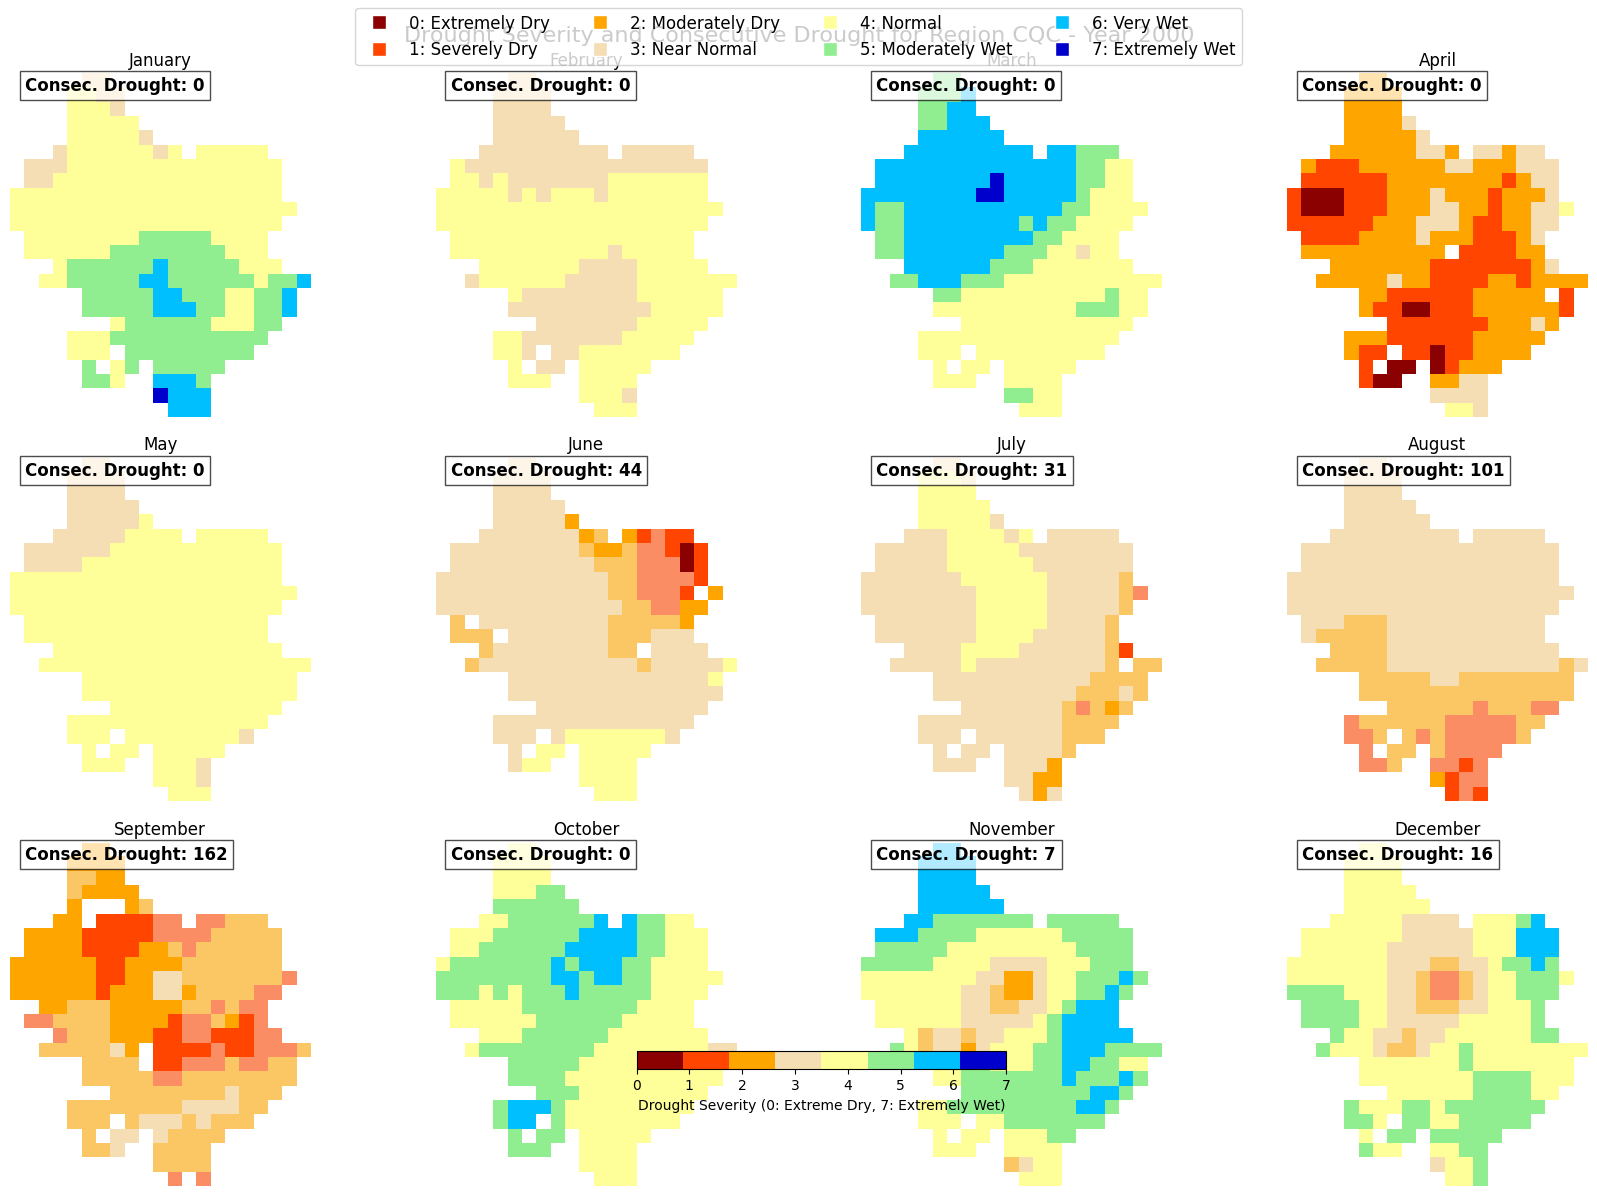

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# === Load the Labeled Region File ===
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc"  # Change this to your file path
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[0].item()
year_data = ds.sel(time=str(first_year))

# === SPI Severity Color Mapping (0 to 7) with Transparent NaN Color ===
severity_colors = [
    "#8B0000",  # 0: Dark Red (Extremely Dry)
    "#FF4500",  # 1: Red (Severely Dry)
    "#FFA500",  # 2: Orange (Moderately Dry)
    "#F5DEB3",  # 3: Beige (Near Normal)
    "#FFFF99",  # 4: Light Yellow (Normal)
    "#90EE90",  # 5: Light Green (Moderately Wet)
    "#00BFFF",  # 6: Light Blue (Very Wet)
    "#0000CD"   # 7: Dark Blue (Extremely Wet)
]
cmap = ListedColormap(severity_colors, name="SPI_Severity", N=8)

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
fig.suptitle(f"Drought Severity and Consecutive Drought for Region CQC - Year {first_year}", fontsize=16)

# === Plot Drought Severity + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):  # Only 12 months
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot Drought Severity (Masking NaN Values) ===
    severity = month_data["drought_severity"].values
    severity_masked = np.ma.masked_where(np.isnan(severity), severity)
    
    # === Set Transparent Background for NaN Values ===
    ax.imshow(np.full_like(severity, np.nan), cmap="Greys", vmin=0, vmax=1, alpha=0.0)
    severity_plot = ax.imshow(severity_masked, cmap=cmap, vmin=0, vmax=7)
    
    ax.set_title(str(month.dt.strftime('%B').item()))
    ax.axis('off')
    
    # === Overlay Consecutive Droughts (Transparent Blue) ===
    consecutive = month_data["consecutive_drought"]
    consecutive_mask = np.ma.masked_where(consecutive == 0, consecutive)
    ax.imshow(consecutive_mask, cmap="Blues", alpha=0.4)
    
    # === Display Consecutive Drought Count ===
    total_consecutive = int(consecutive.sum().item())
    ax.text(0.05, 0.95, f"Consec. Drought: {total_consecutive}",
            transform=ax.transAxes, fontsize=12, color="black", weight="bold",
            bbox=dict(facecolor="white", alpha=0.7))

# === Colorbar (SPI Severity) ===
cbar = fig.colorbar(severity_plot, ax=axes, orientation="horizontal", fraction=0.02, pad=0.05)
cbar.set_label("Drought Severity (0: Extreme Dry, 7: Extremely Wet)")

# === Legend for Colors ===
legend_colors = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10)
                 for color in severity_colors]
legend_labels = [
    "0: Extremely Dry", "1: Severely Dry", "2: Moderately Dry", 
    "3: Near Normal", "4: Normal", "5: Moderately Wet", 
    "6: Very Wet", "7: Extremely Wet"
]
fig.legend(legend_colors, legend_labels, loc='upper center', fontsize=12, ncol=4)

plt.tight_layout()
plt.show()


In [3]:
import xarray as xr

# Load the dataset
file_path = r"Data - Modelling\Region_Monthly_DB\3. Labelled Files\NET_Combined_Labeled.nc"
ds = xr.open_dataset(file_path)

# Count of NaN values for each variable
nan_counts_per_var = ds.isnull().sum()
print("NaN count per variable:")
print(nan_counts_per_var)


NaN count per variable:
<xarray.Dataset> Size: 64B
Dimensions:              ()
Data variables:
    monthly_rain         int64 8B 64800
    max_temp             int64 8B 64800
    min_temp             int64 8B 64800
    radiation            int64 8B 64800
    spi_1                int64 8B 64800
    drought              int64 8B 64800
    drought_severity     int64 8B 65125
    consecutive_drought  int64 8B 144341
